# Changing Turbine Governor Setpoints

This notebook shows an example of changing the generator setpoints in a time-domain simulation. Data in this example is trivial, but the example can be retrofitted for scenarios such as economic dispatch incorporation or reinforcement learning.

Steps are the folllwing:

1. Initialize a system by running the power flow,
2. Set the first simulation stop time in `TDS.config.tf`,
3. Run the simulation,
3. Update the setpoints,
4. Set the new simulation stop time and repeat from 3 until the end.

## Step 1: Case Setup

In [1]:
import andes
from andes.utils import get_case

In [21]:
kundur = get_case('kundur/kundur_full.xlsx')

ss = andes.run(kundur)

Working directory: "/Users/hcui7/repos/andes/examples"
Loaded config from file "/Users/hcui7/.andes/andes.rc"
Parsing input file "/Users/hcui7/repos/andes/andes/cases/kundur/kundur_full.xlsx"
Input file parsed in 0.0673 seconds.

-> Power flow calculation
Sparse Solver: KLU
Method: NR method
Power flow initialized.
0: |F(x)| = 14.9283   
1: |F(x)| = 3.60858   
2: |F(x)| = 0.17009   
3: |F(x)| = 0.00203822
4: |F(x)| = 3.76399e-07
Converged in 5 iterations in 0.0089 seconds.
Report saved to "kundur_full_out.txt" in 0.0012 seconds.
-> Single process finished in 0.1713 seconds.


In [22]:
# disable the Toggler in this case
ss.Toggler.alter('u', 1, 0)

## Step 2: Set the First Stop Time

In [23]:
# simulate to t=1 sec

# specify the first stop in `ss.TDS.config.tf`
ss.TDS.config.tf = 1

## Step 3: Run Simulation

In [24]:
ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0-1 sec.
Fixed step size: h=33.33 msec., shrink if not converged
Initialization was successful in 0.0239 seconds.


100%|██████████████████████████████| 100/100 [00:00<00:00, 1398.27%/s]

Simulation completed in 0.0720 seconds.
TDS outputs saved in 0.0039 seconds.


True

## Step 4. Apply the auxiliary power setpoints to `TGOV1.paux0.v`

First, let's check the equations of TGOV1. `ss.TGOV1.paux0` is associated with equation `0 = paux - paux0`, in which `paux` is added to the power input equation.

In [25]:
print(ss.TGOV1.doc())

Model <TGOV1> in Group <TurbineGov>

    TGOV1 model.
    
Parameters

 Name  |      Description      | Default | Unit |   Type    |    Properties   
-------+-----------------------+---------+------+-----------+-----------------
 idx   | unique device idx     |         |      | DataParam |                 
 u     | connection status     | 1       | bool | NumParam  |                 
 name  | device name           |         |      | DataParam |                 
 syn   | Synchronous generator |         |      | IdxParam  | mandatory,unique
       | idx                   |         |      |           |                 
 Tn    | Turbine power rating. |         | MVA  | NumParam  |                 
       | Equal to Sn if not    |         |      |           |                 
       | provided.             |         |      |           |                 
 wref0 | Base speed reference  | 1       | p.u. | NumParam  |                 
 R     | Speed regulation gain | 0.050   | p.u. | NumParam  

In [26]:
ss.TGOV1.paux0.v

array([0., 0., 0., 0.])

In [27]:
# look up the original values of TGOV1 make sure they are as expected

ss.TGOV1.paux0.v

array([0., 0., 0., 0.])

In [28]:
# MUST use in-place assignments. 
# Here, we increase the setpoint of the 0-th generator

ss.TGOV1.paux0.v[0] = 0.05

In [29]:
ss.TGOV1.paux0.v

array([0.05, 0.  , 0.  , 0.  ])

Continue to simulate to 2 seconds.

In [30]:
ss.TDS.config.tf = 2

In [31]:
ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 1.0-2 sec.
Fixed step size: h=33.33 msec., shrink if not converged


100%|█████████████████████████████| 100.0/100 [00:00<00:00, 367.50%/s]

Simulation completed in 0.2725 seconds.
TDS outputs saved in 0.0093 seconds.


True

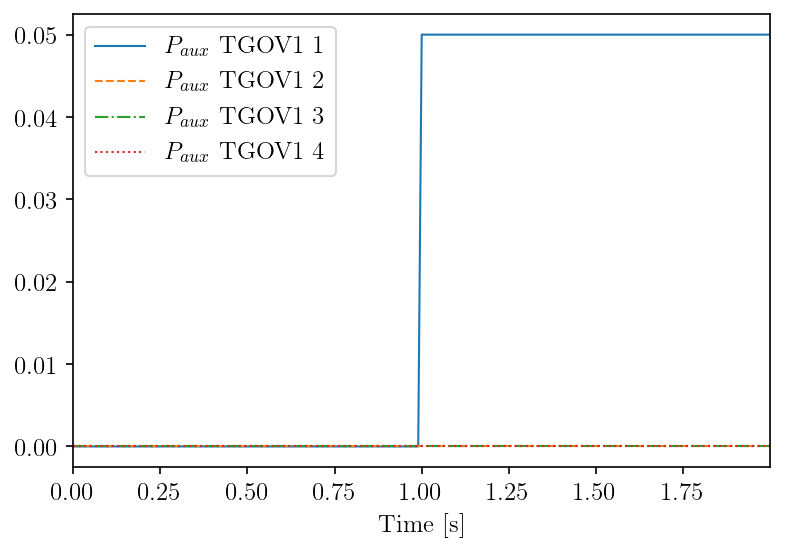

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faef6502eb8>)

In [32]:
ss.TDS.plotter.plot(ss.TGOV1.paux)

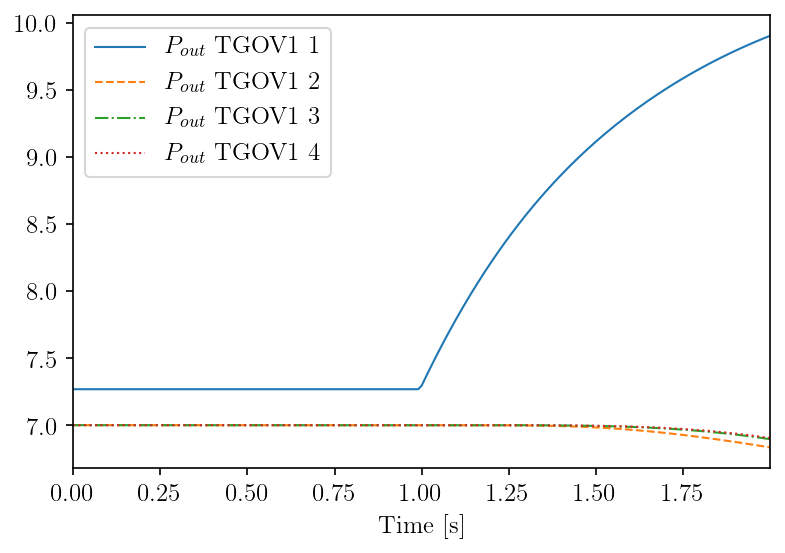

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faef698dc88>)

In [33]:
ss.TDS.plotter.plot(ss.TGOV1.pout)

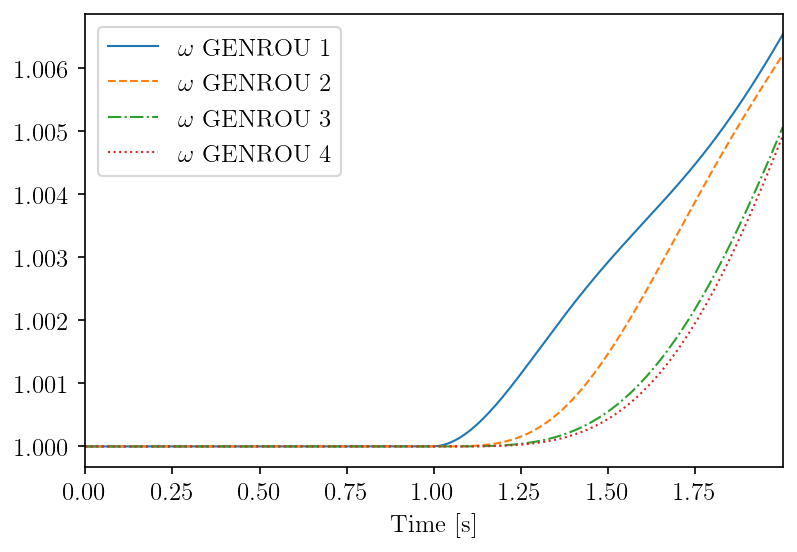

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faef6bba278>)

In [34]:
ss.TDS.plotter.plot(ss.GENROU.omega)

## Step 5: Set Another New Setpoints and New Ending TIme.

In this example, we clear the auxiliary power previously set to `TGOV1.paux0.v`

In [35]:
# use in-place assignment again

ss.TGOV1.paux0.v[0] = 0.

# set the new ending time to 10 sec.
ss.TDS.config.tf = 10

In [36]:
ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 2.0-10 sec.
Fixed step size: h=33.33 msec., shrink if not converged


100%|██████████████████████████████| 100.0/100 [00:02<00:00, 38.72%/s]

Simulation completed in 2.5830 seconds.


TDS outputs saved in 0.0509 seconds.


True

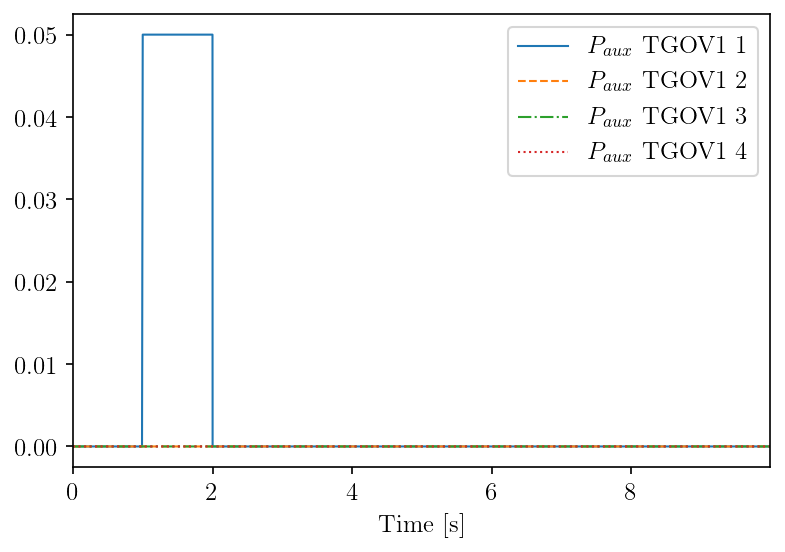

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faef6d9dbe0>)

In [37]:
ss.TDS.plotter.plot(ss.TGOV1.paux)

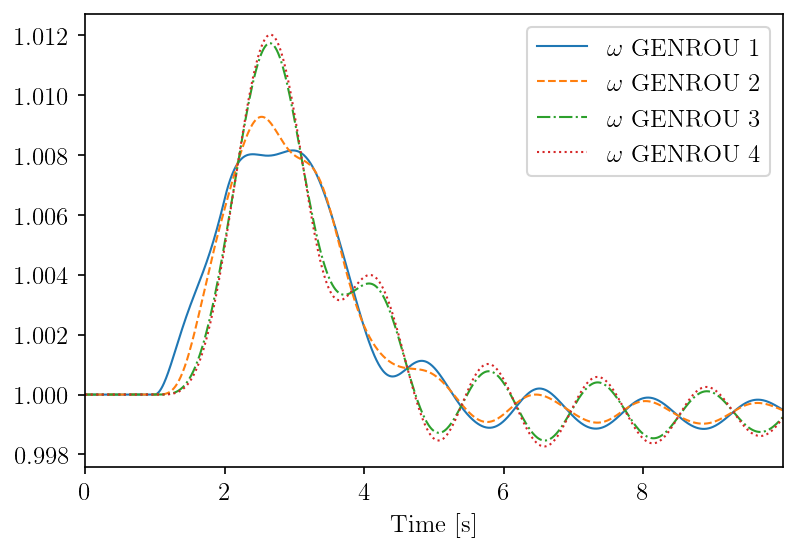

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faef6911ef0>)

In [38]:
ss.TDS.plotter.plot(ss.GENROU.omega)